# Temperaturna analiza

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [108]:
df_meteo = pd.read_csv("../data/HR000142360.csv")
df_energy = pd.read_csv("../data/1EG.csv")

Uvodimo novi skup podataka preuzet sa: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-month?bbox=45.944,15.848,45.684,16.108&pageNum=1&pageSize=10

In [94]:
df_weather['DATE_DT'] = pd.to_datetime(df_weather['DATE'])
df_weather['GODINA'] = df_weather['DATE_DT'].dt.year
df_weather['MJESEC'] = df_weather['DATE_DT'].dt.month

# TAVG - prosjecna temperatura po mjesecu
# HTDD - koliko dana u mjesecu je temperatura bila ispod 18 stupnjeva (pali se grijanje)
weather_cols = ['GODINA', 'MJESEC', 'TAVG', 'HTDD']
df_weather_subset = df_weather[weather_cols]
    
df = pd.merge(
    df_energy, 
    df_weather_subset, 
    on=['GODINA', 'MJESEC'], 
    how='left'
)
df.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR,TAVG,HTDD
0,22419412,NaN,NaN,-0.866025,0.5,10,2010,0.019850,3.494,10.82,232.9
1,22419413,NaN,NaN,-0.866025,0.5,10,2010,0.009742,1.153,10.82,232.9
2,22419415,NaN,NaN,-0.866025,0.5,10,2010,0.044751,5.955,10.82,232.9
3,22419420,NaN,NaN,-0.866025,0.5,10,2010,0.007539,1.829,10.82,232.9
4,22419422,NaN,NaN,-0.866025,0.5,10,2010,0.053865,4.536,10.82,232.9


Opet izdvajamo samo private stanove i one gdje postoji zapis za potrosnju i povrsinu.

In [95]:
df = df[df['ENESGR'].notna() & (df['ENESGR'] != 0)]
df = df[df['ID_STANA']>40_000_000]
df = df[df['POVRSINA'].notna() & (df['POVRSINA'] != 0)]
# Dodatno dodajemo datetime objekt za grafove.
df['DATUM'] = pd.to_datetime({
    'year': df['GODINA'],
    'month': df['MJESEC'],
    'day': 1
})
df.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR,TAVG,HTDD,DATUM
64707,424100150014,140.0,NaN,0.5,0.866025,1,2012,0.019411,3.460,3.81,450.2,2012-01-01
64708,424100160010,110.0,NaN,0.5,0.866025,1,2012,0.011281,3.859,3.81,450.2,2012-01-01
64709,424100230018,200.0,NaN,0.5,0.866025,1,2012,0.012551,0.526,3.81,450.2,2012-01-01
64710,424100200011,120.0,NaN,0.5,0.866025,1,2012,0.028067,5.267,3.81,450.2,2012-01-01
64711,424100210017,300.0,NaN,0.5,0.866025,1,2012,0.028397,3.909,3.81,450.2,2012-01-01


In [96]:
df.info()

<class 'pandas.DataFrame'>
Index: 89799 entries, 64707 to 661179
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID_STANA    89799 non-null  int64         
 1   POVRSINA    89799 non-null  float64       
 2   BR_OSOBA    22904 non-null  float64       
 3   MJESEC_sin  89799 non-null  float64       
 4   MJESEC_cos  89799 non-null  float64       
 5   MJESEC      89799 non-null  int64         
 6   GODINA      89799 non-null  int64         
 7   S_SNAGA     89799 non-null  float64       
 8   ENESGR      89799 non-null  float64       
 9   TAVG        76036 non-null  float64       
 10  HTDD        76036 non-null  float64       
 11  DATUM       89799 non-null  datetime64[us]
dtypes: datetime64[us](1), float64(8), int64(3)
memory usage: 8.9 MB


## Grafovi

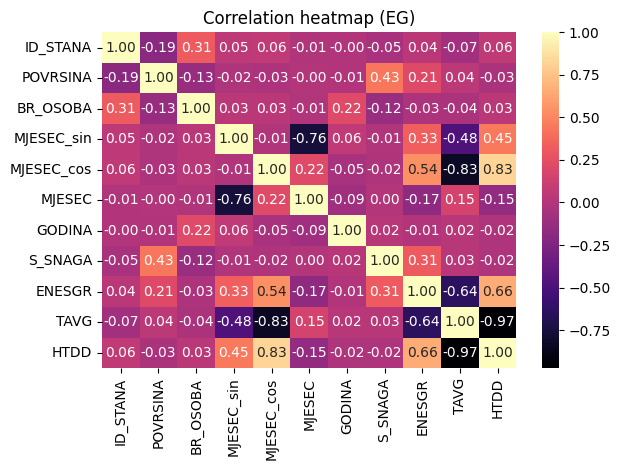

In [97]:
corr = df.corr(numeric_only=True)

ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")

plt.tight_layout()
plt.show()

Ovdje vidimo da 2 nova parametra imaju zapravo najvecu korelaciju sa nasim ciljanim parametrom.

In [115]:
def diagnose_features(data, features, target):
    """
    Metoda za graficki pregled trendova u podatcima.
    """
    num_features = len(features)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Crtamo podatke i trend
        sns.regplot(
            data=data, 
            x=col, 
            y=target, 
            ax=axes[i],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True # Lowess crta liniju koja prati lokalni trend (otkriva zakrivljenost)
        )
        axes[i].set_title(f'{target} vs {col}')
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # Brišemo prazne grafove ako ih ima
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


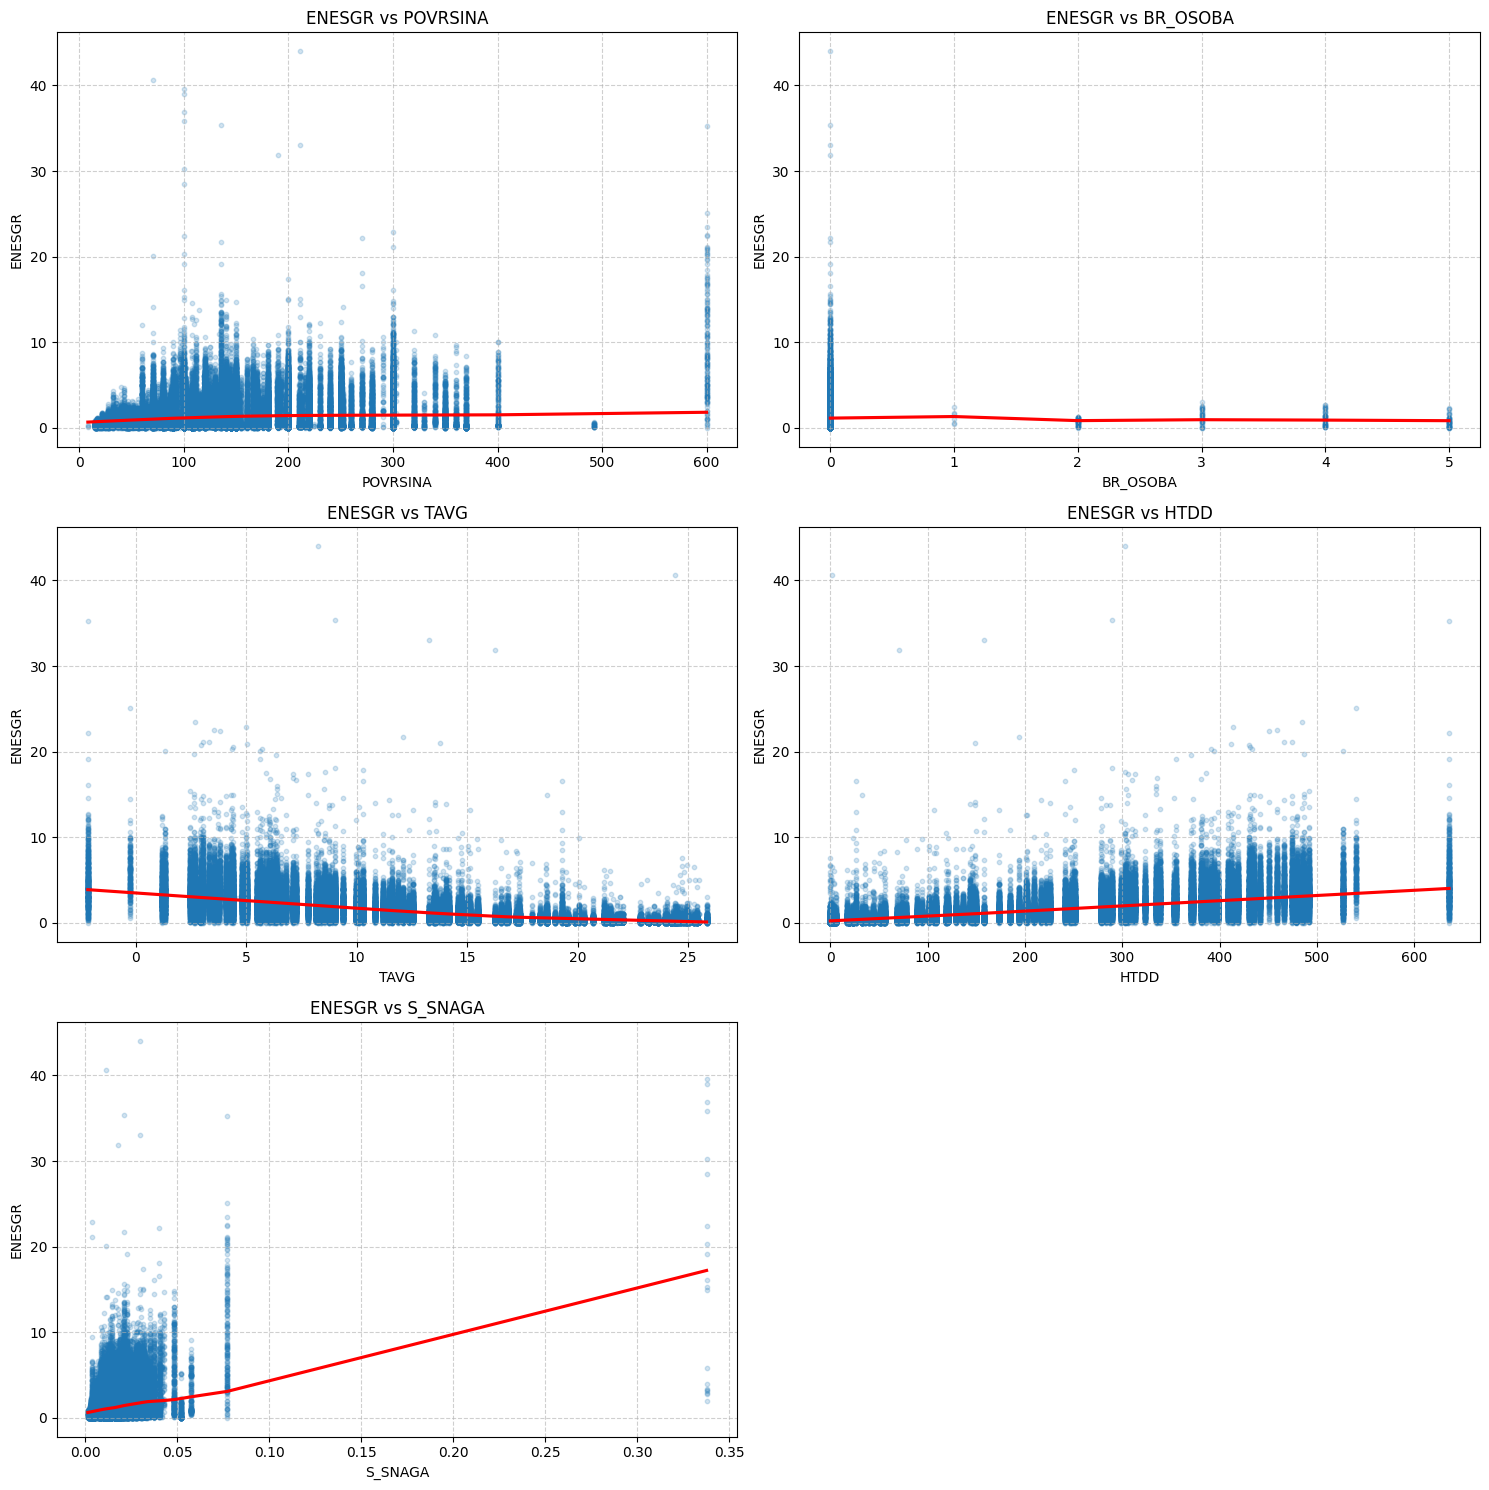

In [116]:
diagnose_features(df, ['POVRSINA', 'BR_OSOBA', 'TAVG', 'HTDD', 'S_SNAGA'], 'ENESGR')

## Regresije i invervali pouzdanosti 

In [98]:
def filter_burn_in(df, values=1):
    """
    Metoda za micanje prvih par podataka.
    """
    df = df.copy()
    df = df.sort_values(['ID_STANA', 'DATUM'])
    df['temp_row_count'] = df.groupby('ID_STANA').cumcount()
    df_filtered = df[df['temp_row_count'] >= values].copy()
    df_filtered = df_filtered.drop(columns=['temp_row_count'])
    return df_filtered

In [99]:
from sklearn.linear_model import LinearRegression

def calculate_weather_normalized_anomalies(df):
    df['EXPECTED_BY_TEMP'] = np.nan
    df['RESIDUAL'] = np.nan
    
    for target_id in df['ID_STANA'].unique():
        # Izbaci redove gdje fali HTDD ili ENESGR
        subset = df[df['ID_STANA'] == target_id].copy()
        subset_clean = subset.dropna(subset=['HTDD', 'ENESGR'])
        
        if len(subset_clean) < 5:
            continue 
            
        # Fit modela
        X = subset_clean[['HTDD']].values
        y = subset_clean['ENESGR'].values
        
        model = LinearRegression().fit(X, y)
        
        # Predikcija 
        valid_idx = subset[subset['HTDD'].notna()].index
        X_valid = subset.loc[valid_idx, ['HTDD']].values
        
        preds = model.predict(X_valid)
        
        df.loc[valid_idx, 'EXPECTED_BY_TEMP'] = preds
        df.loc[valid_idx, 'RESIDUAL'] = df.loc[valid_idx, 'ENESGR'] - preds

    return df

In [100]:
df_filtered = filter_burn_in(df, 2)
df_anomalies = calculate_weather_normalized_anomalies(df_filtered)
df_anomalies.head()

,ID_STANA,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR,TAVG,HTDD,DATUM,EXPECTED_BY_TEMP,RESIDUAL
73810,424100010018,130.0,NaN,1.000000e+00,6.123234e-17,3,2012,0.020988,2.106,11.59,209.1,2012-03-01,1.237221,0.868779
81360,424100010018,130.0,NaN,8.660254e-01,-5.000000e-01,4,2012,0.020988,1.084,13.79,148.2,2012-04-01,0.900180,0.183820
86191,424100010018,130.0,NaN,5.000000e-01,-8.660254e-01,5,2012,0.020988,0.300,17.92,50.0,2012-05-01,0.356709,-0.056709
88637,424100010018,130.0,NaN,1.224647e-16,-1.000000e+00,6,2012,0.020988,0.100,23.13,1.7,2012-06-01,0.089400,0.010600
92596,424100010018,130.0,NaN,-5.000000e-01,-8.660254e-01,7,2012,0.020988,0.100,25.30,0.2,2012-07-01,0.081099,0.018901


In [101]:
def finalize_weather_anomalies(df, threshold=3.5):
    """
    Metoda za odredivanje anomalija na temelju Z-scorea reziduala.
    """ 
    grouped = df.groupby('ID_STANA')['RESIDUAL']
    
    df['RES_MEDIAN'] = grouped.transform('median')
    df['RES_MAD'] = grouped.transform(lambda x: np.median(np.abs(x - np.median(x))))
    df['RES_STD'] = df['RES_MAD'] * 1.4826
    
    # Z-score-a na rezidualima
    df['Z_SCORE_RES'] = (df['RESIDUAL'] - df['RES_MEDIAN']) / (df['RES_STD'] + 1e-6)
    df['ANOM'] = df['Z_SCORE_RES'] > threshold
    
    return df

In [111]:
df_anomalies = finalize_weather_anomalies(df_anomalies)
anom_cnt = df_anomalies['ANOM'].sum()
perc = (anom_cnt / len(df_anomalies)) * 100
print(f"Pronađeno {anom_cnt} anomalija, što je {perc:.2f}% od ukupnog broja očitanja.")
# df_anomalies.head()

Pronađeno 142 anomalija, što je 0.16% od ukupnog broja očitanja.


In [112]:
def plot_weather_anomalies_grid(df, max_plots=10, cols=2, threshold=3):
    """
    Metoda za prikaz vise stanova s anomalijama na jednoj slici (grid format).
    """
    anomalous_ids = df[df['ANOM'] == True]['ID_STANA'].unique()
    
    if len(anomalous_ids) == 0:
        print("Nema pronađenih anomalija na temelju reziduala.")
        return

    ids_to_plot = anomalous_ids[:max_plots]
    n_plots = len(ids_to_plot)
    rows = math.ceil(n_plots / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 5))
    
    if n_plots > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for i, target_id in enumerate(ids_to_plot):
        ax = axes_flat[i]
        # Filtriramo i sortiramo po datumu
        subset = df[df['ID_STANA'] == target_id].sort_values('DATUM')
        anomalies = subset[subset['ANOM'] == True]

        # Interval pouzdanosti
        lower_bound = (subset['EXPECTED_BY_TEMP'] - threshold * subset['RES_STD']).clip(lower=0)
        upper_bound = subset['EXPECTED_BY_TEMP'] + threshold * subset['RES_STD']
        
        ax.fill_between(subset['DATUM'], lower_bound, upper_bound, 
                        color='gray', alpha=0.15, label=f'±{threshold} STD (Meteo normala)')
        
        # Linija ocekivane potrosnje
        ax.plot(subset['DATUM'], subset['EXPECTED_BY_TEMP'], color='green', 
                linestyle='--', linewidth=1.5, alpha=0.7, label='Očekivano (Linear Reg)')
        
        # Stvarna potrosnja
        sns.lineplot(data=subset, x='DATUM', y='ENESGR', 
                     ax=ax, color='steelblue', linewidth=2, label='Stvarna ENESGR')

        # Anomalije
        ax.scatter(anomalies['DATUM'], anomalies['ENESGR'], 
                    color='red', s=60, edgecolor='black', zorder=5, label='Anomalija')

        ax.set_title(f"Meteo-korigirana analiza | Stan: {target_id}", fontsize=12)
        ax.grid(True, linestyle=':', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel("Potrošnja")
        ax.set_xlabel("")
        
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.suptitle("Detekcija anomalija nakon normalizacije temperaturom", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

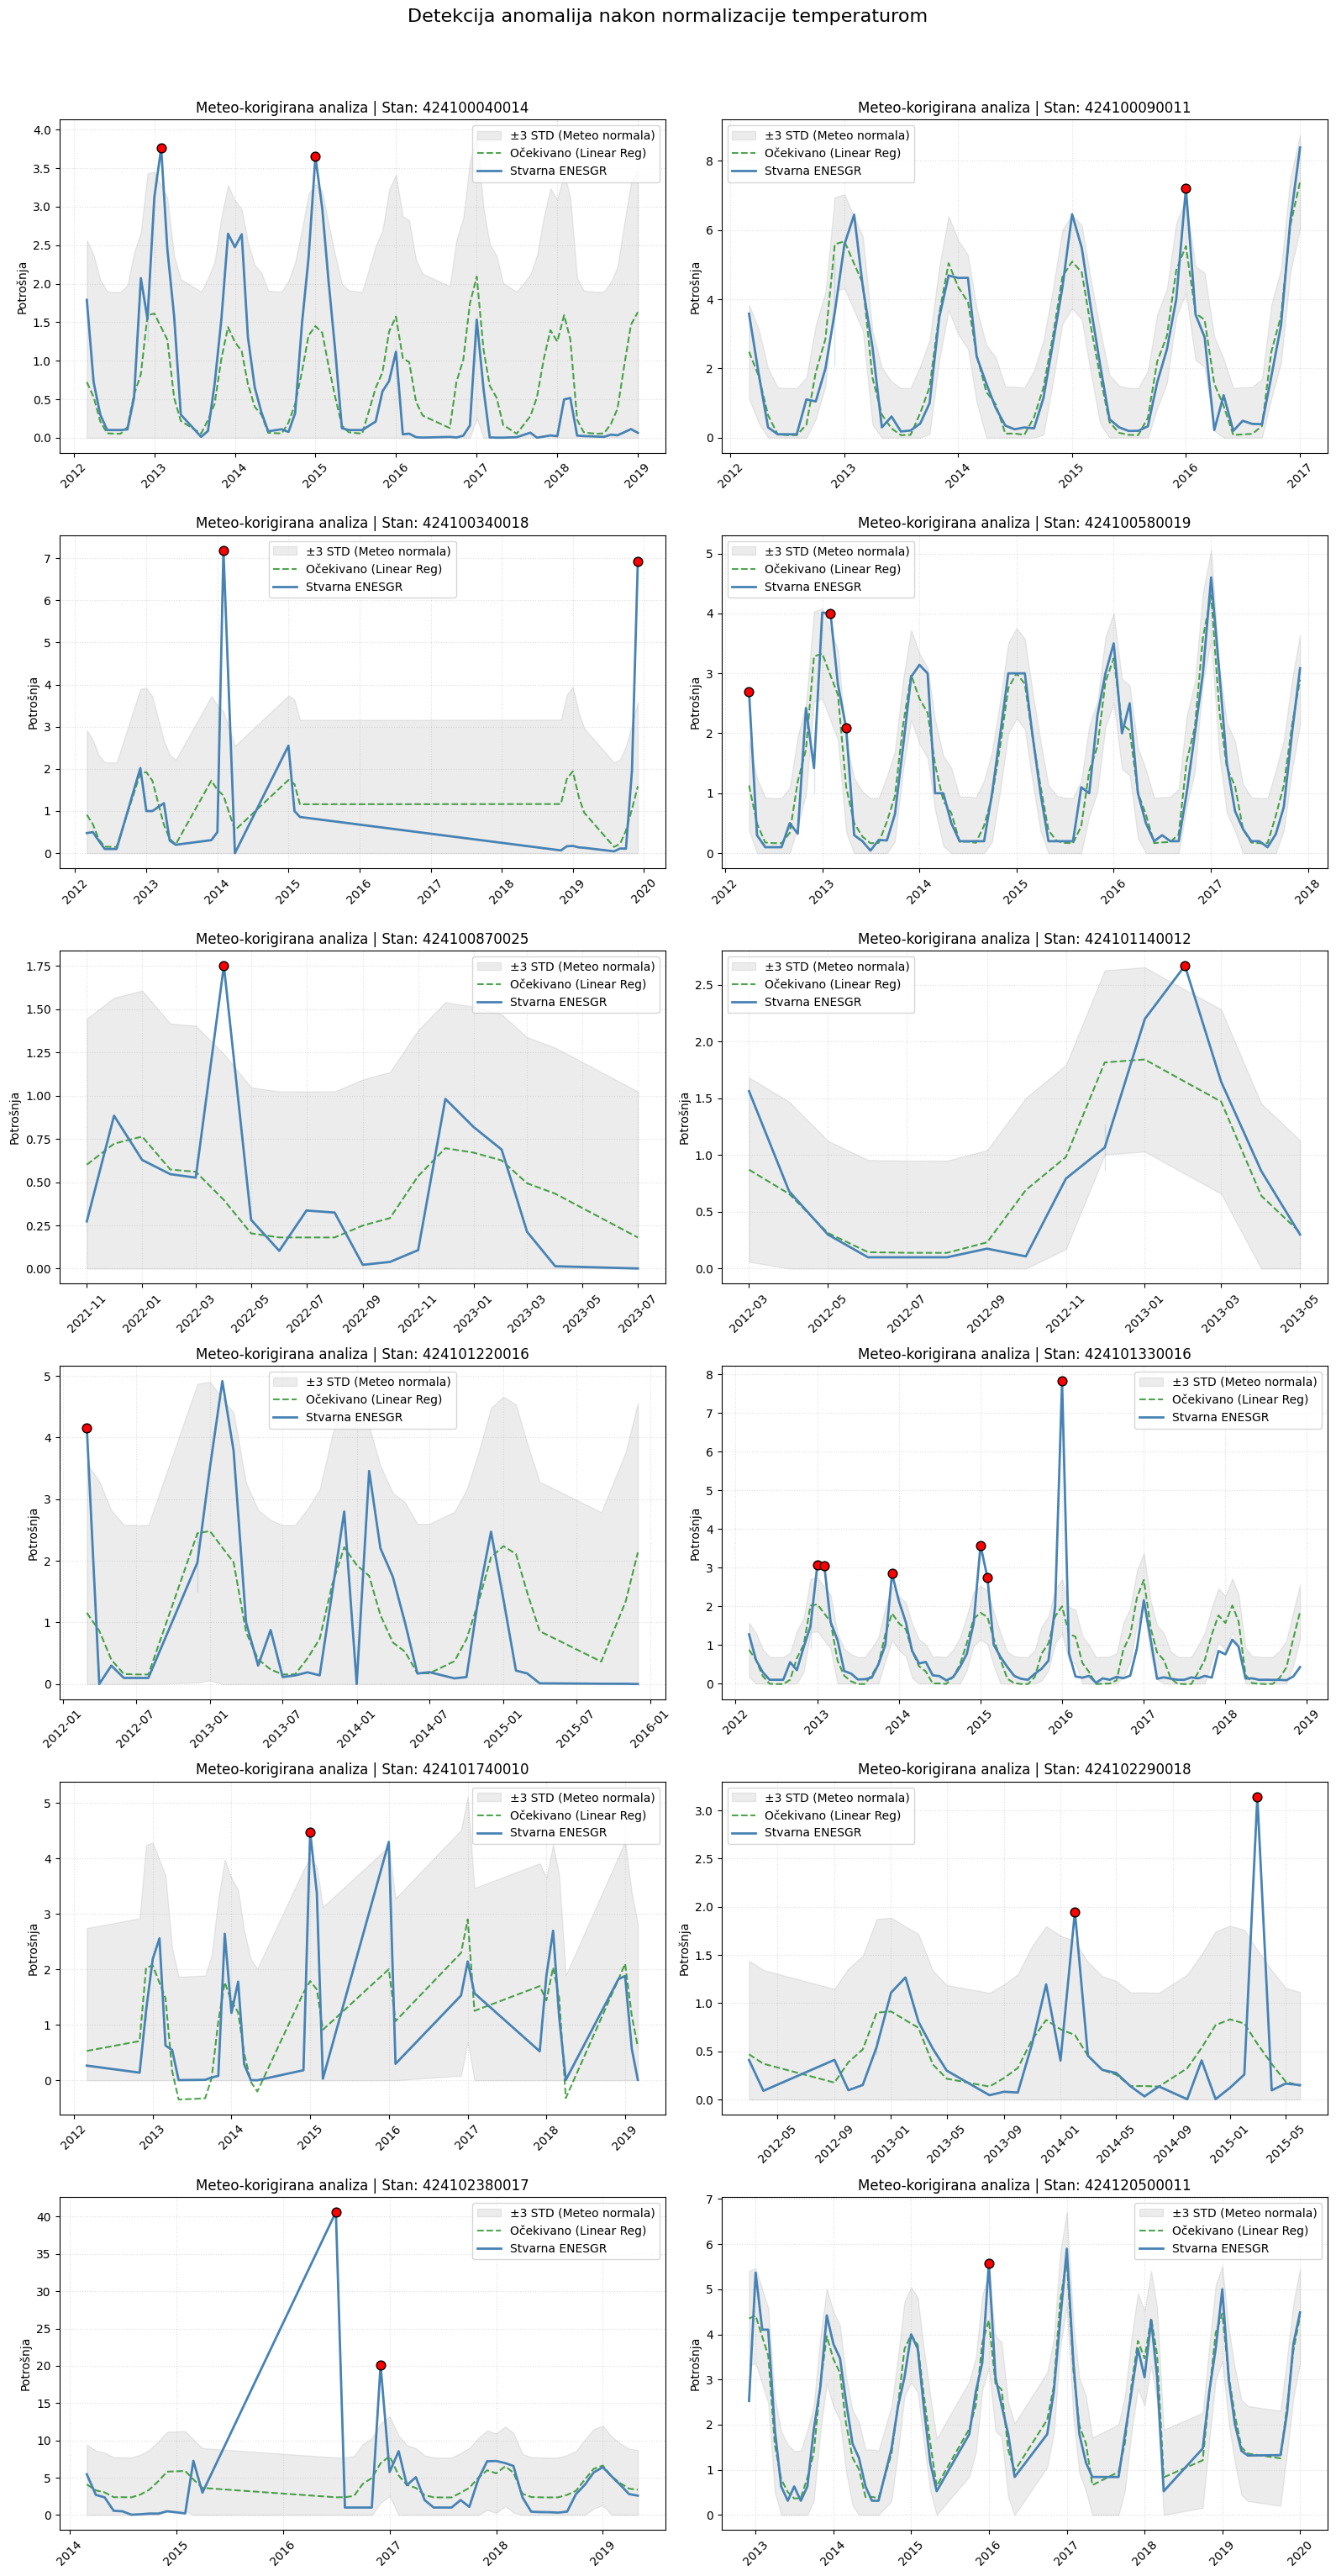

In [114]:
plot_weather_anomalies_grid(df_anomalies, max_plots=12, threshold=3)